In [1]:
import numpy as np
import time

In [93]:
def stringfy(vec):
    return ''.join([str(x) for x in vec])
import itertools
perm = list(itertools.permutations([0,1,2,3]))
ORDER = []
for x in perm:
    el= ''.join([str(y) for y in x])
    ORDER.append(el)

ORDER = np.array(ORDER)

In [94]:
ORDER

array(['0123', '0132', '0213', '0231', '0312', '0321', '1023', '1032',
       '1203', '1230', '1302', '1320', '2013', '2031', '2103', '2130',
       '2301', '2310', '3012', '3021', '3102', '3120', '3201', '3210'],
      dtype='<U4')

In [103]:
ACTIONS = {
    'UP' : 0,
    'RIGHT' : 1,
    'DOWN' : 2,
    'LEFT' : 3,
}
INVERSE_ACTIONS = {
    0 : 'UP',
    1 : 'RIGHT',
    2 : 'DOWN',
    3 : 'LEFT',
}
class Puzzle4():
    def __init__(self):
        self.config = np.array([0,1,2,3])
        np.random.shuffle(self.config)
        self.final_state = np.array([0,1,2,3])
        self.done = False
        self.num_iter = 0

    def reset(self):
        np.random.shuffle(self.config)
        self.done = False
        self.num_iter = 0
        return stringfy(self.config)

        

    def get_legal_action(self):
        idx_0 = np.argwhere(self.config == 0)[0][0]
        if idx_0 == 0:
            return [ACTIONS['RIGHT'],ACTIONS['DOWN']]
        elif idx_0 == 1:
            return [ACTIONS['LEFT'],ACTIONS['DOWN']]
        elif idx_0 == 2:
            return [ACTIONS['RIGHT'],ACTIONS['UP']]
        else:
            return [ACTIONS['LEFT'],ACTIONS['UP']]

    def action_space(self):
        return 4
        
        
    def step(self,action):
        self.num_iter += 1

        if self.num_iter > 20:
            self.done = True
            return stringfy(self.config), 0, self.done
        if self.done:
            raise Exception('Game is over')
        idx_0 = np.argwhere(self.config == 0)[0][0]
        if action == 0:
            dst = idx_0 - 2 
        elif action == 1:
            dst = idx_0 + 1
        elif action == 2:
            dst = idx_0 + 2
        elif action == 3:
            dst = idx_0 - 1
        else: 
            raise Exception('Invalid action')
    
        self.config[idx_0] = self.config[dst]
        self.config[dst] = 0

        #self.render()


        if np.array_equal(self.config,self.final_state):
            self.done = True
            return stringfy(self.config), 1, self.done
        else:
            return stringfy(self.config), 0, self.done

    
        
    def render(self):
        print(self.config)
    

In [6]:
class QTable():
    def __init__(self,env,eps,alpha,gamma):
        self.env = env
        self.q_table = np.zeros((np.math.factorial(4),env.action_space()))
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
    def train(self,num_episodes):
        for _ in range(num_episodes):
            state = self.env.reset()
            idx_state = np.argwhere(ORDER == state)[0][0]
            done = False
            while not done:
                if np.random.random() < self.eps:
                    action = np.random.choice(self.env.get_legal_action())
                else:
                    action = np.argmax(self.q_table[idx_state])
                
                new_state,reward,done = self.env.step(action)
                idx_new_state = np.argwhere(ORDER == new_state)[0][0]
                
                
                self.q_table[idx_state,action] =self.q_table[idx_state,action] + self.alpha*(reward + self.gamma*np.max(self.q_table[idx_new_state,:]-self.q_table[idx_state,action]))
                state = new_state
                idx_state = idx_new_state

                #time.sleep(0.5)
        

In [7]:
env = Puzzle4()
q_table = QTable(env,0.1,0.1,0.9)

In [38]:
q_table.train(20000)

In [40]:
state = env.reset()
done = False
while not done:
    action = np.argmax(q_table.q_table[np.argwhere(ORDER == state)[0][0]])
    state,reward,done = env.step(action)
    env.render()
    time.sleep(0.5)


[0 2 3 1]
[2 0 3 1]
[2 1 3 0]
[2 1 0 3]
[0 1 2 3]


In [104]:
A = np.zeros((np.math.factorial(4),np.math.factorial(4)))
edge_labels = {}

for i in range(np.math.factorial(4)):
    idx_state = i
    state = ORDER[i]
    # convert to list of int
    state = np.array([int(x) for x in state])
    action = np.argmax(q_table.q_table[i])
    idx_0 = np.argwhere(state == 0)[0][0]
    if action == 0:
        dst = idx_0 - 2 
    elif action == 1:
        dst = idx_0 + 1
    elif action == 2:
        dst = idx_0 + 2
    elif action == 3:
        dst = idx_0 - 1
    else: 
        raise Exception('Invalid action')
    new_state = state.copy()
    new_state[idx_0] = new_state[dst]
    new_state[dst] = 0
    new_state = stringfy(new_state)
    idx_new_state = np.argwhere(ORDER == new_state)[0][0]
    

    edge_labels[(idx_state,idx_new_state)] = INVERSE_ACTIONS[action]
    A[idx_state,idx_new_state] = 1


In [72]:
def get_nodes_from(A, start):
    m,n = A.shape
    l = [start]
    ret = []
    while len(l)>0:
        node = l.pop(0)
        if node in ret:
            continue
        ret.append(node)
        for x in range(n):
            if A[node,x] == 1:
                
                l.append(x)
    return ret


['0123', '1023']

In [73]:
nodes_with_solution = []
for i in range(np.math.factorial(4)):
    if 0 in get_nodes_from(A,i):
        nodes_with_solution.append(i)

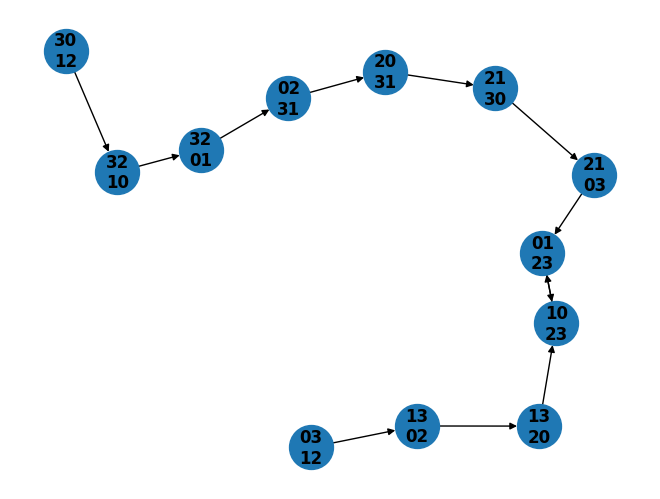

In [130]:

import networkx as nx
import matplotlib.pyplot as plt

# create a directed graph
G = nx.DiGraph()
edge_labels_conv = {}

# Add nodes and edges
for i in range(np.math.factorial(4)):
    for j in range(np.math.factorial(4)):
        if A[i,j] == 1 and i in nodes_with_solution and j in nodes_with_solution:
            v1 = ORDER[i][:2]+"\n"+ORDER[i][2:]
            v2 = ORDER[j][:2]+"\n"+ORDER[j][2:]
            edge_labels_conv[(v1,v2)] = edge_labels[(i,j)]
            G.add_edge(v1,v2)

pos = nx.spring_layout(G)
# Draw the graph, show the orientation of the edges, make it in
nx.draw(G, with_labels=True, font_weight='bold',pos=pos,node_size=1000,arrowsize=10)


plt.show()

